# comp_scat_BHM11-vs-simu
compute decaying length scale of internal tide, following Buhler & Holmes-Cerfon 2011, and De Lavergne et al 2019 for the topographic scattering

Theoretical estimate based topography corrugations : 
$$\lambda_H^\text{decay} = \frac{2\overline{H}^2}{\pi \Gamma_0}\left(\overline{(H-\overline{H})^2}\overline{|\nabla H|^2}\right)^{-1/2}$$
with $\Gamma_0$ a constant ($\sqrt{2\pi}$ in De Lavergne et al 2019). Overline indicates running mean.

N.B.: not comparing with btrop/bclin separation. Indeed you could estimate a decaying time scale, but not a length scale.

From the modal decomposition, the modal decaying time scale is taken as: $ \tau_n^\text{dec} = E_n/D_n $, and a length scale is recovered using the modal phase speed. Note that $D$ can be the (estimated) dissipation or just the baroclinic scattering term.


In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from matplotlib.animation import FuncAnimation

import numpy as np
from netCDF4 import Dataset#, MFDataset
import scipy.signal as sig
from scipy.ndimage import gaussian_filter
import scipy.interpolate as itp
from PIL import Image, ImageDraw
import json
import pandas as pd

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = KRYPTON+"local_ruchba/"

In [36]:
# informations

simul = "luckym2"

scat_file = KRYPTON+"{0}_modemap/{0}_mode_scatdiag.nc".format(simul)
data_file = "luckym2_diagscat.pkl"
grid_file = KRYPTON+"/lucky_corgrd.nc"
doms_file = "../NRJ_flux_diag/subdomains_lucky.json"
mode_file = KRYPTON+"{0}_modemap/{0}_modemap_20.nc".format(simul)
nrjm_file = KRYPTON+"{0}_modemap/{0}_modenrj_20.nc".format(simul)
dirpic = 'pictures/modal_conv_scatter/'
dosavefig = False

with open(doms_file, "r") as fp:
    mydoms = json.load(fp)      
# unfold subdomains
doms, nams = [], []
for key,val in mydoms.items():
    if key == "ridges":
        for ido,dom in enumerate(val):
            doms.append(dom)
            nams.append(key.rstrip("s")+str(ido+1))
    else:
        doms.append(val)
        nams.append(key)
     
rho0 = 1025
M2 = 2*np.pi/(12.42*3600)
 
datfra = pd.read_pickle(data_file)

In [3]:
### useful routines (need lon, lat before for convienence)

# computing domain averages
def coord_to_pix(pos, lon, lat):
    return np.unravel_index(((lon-pos[0])**2+(lat-pos[1])**2).argmin(), lon.shape)[::-1]

def poly_to_mask(poly,shape):
    img = Image.new('1',shape)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

def polycoord_tomask(coord,lon,lat):
    poly = [coord_to_pix(item, lon, lat) for item in coord]
    return poly_to_mask(poly,lon.shape)

def get_domean(field, dom, lon, lat, maskup=None):
    mask = polycoord_tomask(dom, lon, lat)
    if maskup is not None: mask *= maskup
    return np.nanmean(field[...,mask], axis=(-1))

# define windows and blurring functions
def hann(r):
    return .5*(1+np.cos(np.pi*r))*(r<=1)

def make_win(nwin, win="hann"):
    rad = np.linspace(-1, 1, nwin)
    rad = np.sqrt(rad[:,None]**2+rad[None,:]**2)
    if isinstance(win, str): win = eval(win)
    return win(rad)

def winblur(x, nwin, win="hann", edge_mode="edge"):
    if (nwin%2)==0: nwin+=1
    npad = nwin//2
    window = make_win(nwin, win)
    return sig.convolve(np.pad(x, npad, edge_mode), window, mode="valid")/window.sum()

# test it
if False:
    plt.figure()
    plt.pcolormesh(make_win(100))
    plt.colorbar()

## First, the theory. Based on Buhler & Holmes-Cerfon 2011

In [4]:
# compute grid statistics

# load topo
ncgrd = Dataset(grid_file,'r')
lon = ncgrd.variables['lon_rho'][:]
lat = ncgrd.variables['lat_rho'][:]
topo = ncgrd.variables['h'][:]
dx = np.mean(1./ncgrd.variables['pm'][:])
dy = np.mean(1./ncgrd.variables['pn'][:])
fcor = ncgrd.variables['f'][:]
ncgrd.close()
gradh  = np.sqrt((np.gradient(topo, axis=0)/dy)**2 + (np.gradient(topo, axis=1)/dx)**2)
print("shape :",topo.shape)

shape : (2002, 2002)


In [5]:
### compute hscale, using running mean
Lwin = 100e3
gamo = np.sqrt(2*np.pi)
lawin = "hann"
hmask = 300

nwin = int(round(Lwin/dx))
if (nwin%2)==0: nwin+=1
npad = nwin//2
window = make_win(nwin, lawin)
#print(nwin, npad)

if hmask is not None:
    mask = topo<hmask

tapa = np.pad(topo, npad, "edge")
hmoy = sig.convolve(tapa, window, mode="valid")/window.sum()
hano = sig.convolve(np.pad((topo-hmoy)**2, npad, "reflect"), window, mode="valid")/window.sum()
hpri = sig.convolve(np.pad(gradh**2, npad, "reflect"), window, mode="valid")/window.sum()
hscal = 2*hmoy**2/gamo/np.sqrt(hano*hpri)
hscal[mask] = np.nan

# domain-wise mean
hscales = {"full":np.nanmean(hscal)}
print("mean value on entire domain: {:.1f} km".format(hscales["full"]/1e3))
for dom,nam in zip(doms,nams):
    hscales[nam] = get_domean(hscal, dom, lon, lat, maskup=(topo>hmask))
    print("{0}: {1:.1f} km".format(nam,hscales[nam]/1e3))

mean value on entire domain: 5787.5 km
ridge1: 285.9 km
ridge2: 248.8 km
ridge3: 347.0 km
ridge4: 298.2 km
plain: 6496.7 km
islands: 197.8 km
seamounts: 656.5 km


In [16]:
dosavefig = True

<IPython.core.display.Javascript object>


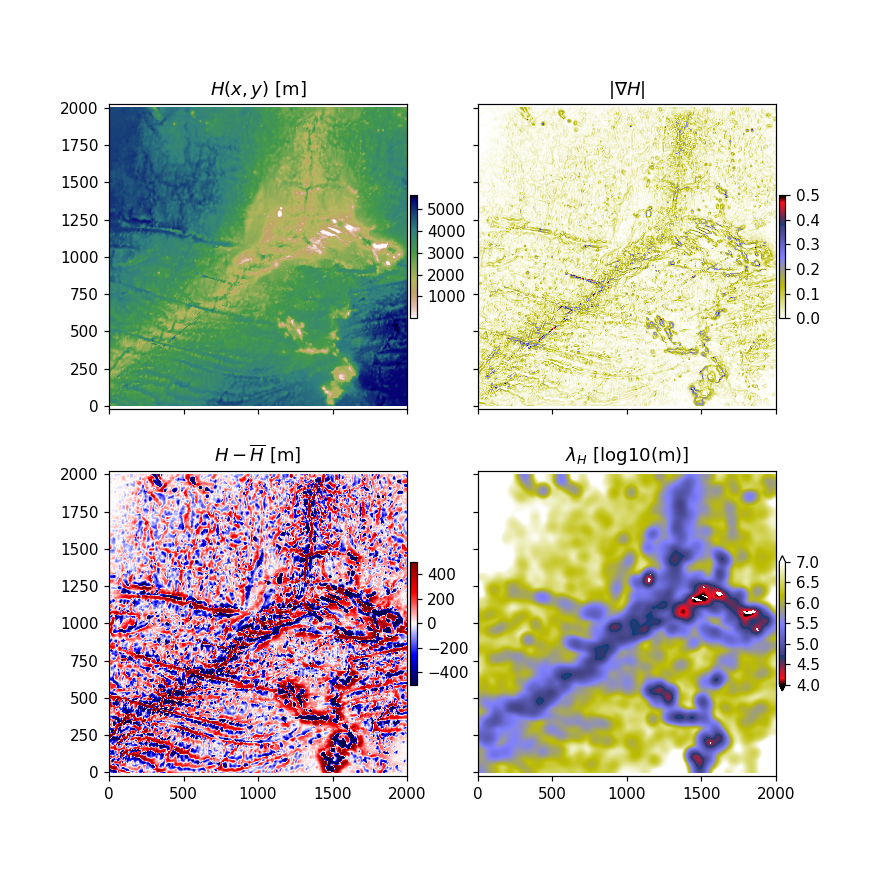

ridge1 285.9 km
ridge2 248.8 km
ridge3 347.0 km
ridge4 298.2 km
plain 6496.7 km
islands 197.8 km
seamounts 656.5 km


In [7]:
# plot results

hamp = 500
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8,8))
ax = axs[0,0]
hpc = ax.pcolormesh(topo, cmap="gist_earth_r")
plt.colorbar(hpc, ax=ax, fraction=.02, pad=.01)
ax.set_title(r'$H(x,y)$ [m]')
ax = axs[0,1]
hpc = ax.pcolormesh(gradh, cmap="gist_stern_r", vmin=0, vmax=.5)
plt.colorbar(hpc, ax=ax, fraction=.02, pad=.01)
ax.set_title(r'$|\nabla H|$')
ax = axs[1,0]
hpc = ax.pcolormesh(topo-hmoy, cmap="seismic", vmin=-hamp, vmax=hamp)
plt.colorbar(hpc, ax=ax, fraction=.02, pad=.01)
ax.set_title(r'$H-\overline{H}$ [m]')
ax = axs[1,1]
hpc = ax.pcolormesh(np.log10(hscal), cmap="gist_stern", vmin=4, vmax=7)
plt.colorbar(hpc, ax=ax, fraction=.02, pad=.01, extend="both")
ax.set_title(r'$\lambda_H $ [log10(m)]')

for ax in axs.ravel():
    ax.set_aspect(1)
    #ax.grid(True)
    
for nam,dom in zip(nams,doms):
    print(nam, "{:.1f} km".format(get_domean(hscal/1e3, dom, lon, lat)))
    
if dosavefig:
    fig.savefig(dirpic+"{}_DecayScale_theory.png".format(simul), magnification="auto", bbox_inches="tight", dpi=150)

## now, the results from the numerical simulation

In [100]:
datfra.T.loc["Cmn","ridge2"][1].sum()*1e3

2.7923985195198284

In [103]:
### First domain-wise estimate using domain-wise energy and dissipation
# N.B.: ridge1 and ridge4 are suspicous
omega = M2

# load phase speed for mode one
nc = Dataset(mode_file, "r")
cpha = nc.variables["mode_speed"][1,...]
xim = nc.variables['xi_rho'][:]
etam = nc.variables['eta_rho'][:]
nc.close()
lonm, latm = lon[:,xim][etam,:], lat[:,xim][etam,:]
fcom = fcor[:,xim][etam,:]

hscaldom = {"full":datfra["Etot","full"][1]/datfra["Diss_tot","full"][1]*np.nanmean(cpha*np.sqrt(1-fcom**2/omega**2))}
print("whole domain averages: {0:.1f} days, {1:.1f} km".format(
    datfra["Etot","full"][1]/datfra["Diss_tot","full"][1] /(24*3.6) ,hscaldom["full"]) )
print("\t scattering: {0:.1f}, res.: {1:.1f}".format(\
                            datfra["Etot","full"][1]/datfra['Cmn',"full"][1].sum()/(24*3.6),\
                            datfra["Etot","full"][1]/datfra["Diss_res","full"][1]/(24*3.6)))
    
for dom,nam in zip(doms,nams):
    cgr = get_domean(cpha*np.sqrt(1-fcom**2/omega**2), dom, lonm, latm, maskup=(topo[:,xim][etam,:]>100))
    etot = datfra["Etot",nam][1] # kJ/m^2 
    diss = datfra['Diss_tot',nam][1] # W/m^2
    czin = datfra['Cmn',nam][1].sum() # W/m^2
    dire = datfra['Diss_res',nam][1]
    taud = etot/diss /(24*3.6) # J/day/m^2
    hscaldom[nam] = etot/diss*cgr # km
    print("{0}: {2:.1f} /day {1:.1f} km".format(nam, hscaldom[nam], taud))
    print("\t scattering: {0:.1f}, res.: {1:.1f}".format(etot/czin/(24*3.6),etot/dire/(24*3.6)))

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


whole domain averages: 5.2 days, 794.2 km
	 scattering: 10.7, res.: 10.0
ridge1: 5.7 /day 875.0 km
	 scattering: 7.2, res.: 27.1
ridge2: 2.2 /day 287.2 km
	 scattering: 3.2, res.: 6.7
ridge3: 2.2 /day 249.7 km
	 scattering: 3.9, res.: 5.0
ridge4: 5.4 /day 673.5 km
	 scattering: 9.5, res.: 12.6
plain: 59.0 /day 9726.0 km
	 scattering: 102.5, res.: 139.0
islands: 3.0 /day 335.1 km
	 scattering: 78.0, res.: 3.1
seamounts: 2.5 /day 381.0 km
	 scattering: 4.0, res.: 6.7


<IPython.core.display.Javascript object>


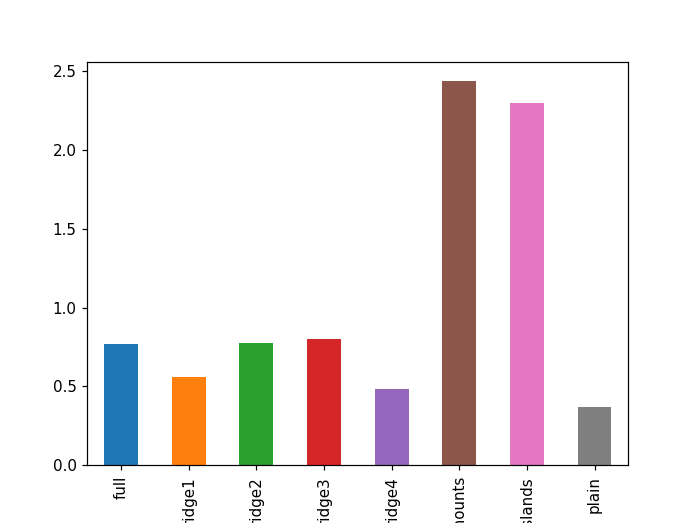

In [46]:
plt.figure()
datfra.iloc[1]["Etot"].plot.bar()

In [18]:
# load mode one, compute dissipation and scattering
imod = 1

doblur = True
if doblur:
    blurfun = lambda x: gaussian_filter(x, sigma=4, mode="constant") # 
else:
    blurfun = lambda x: x

nc = Dataset(scat_file, "r")
dxs, dys = nc.dxdy_subsamp
etot = nc.variables['TotE'][imod,:,:]
diss = nc.variables['DissTot'][imod,:,:]
nc.close()

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [42]:
np.nanmean(etot)

0.77167207

blurring window size: 67


<IPython.core.display.Javascript object>


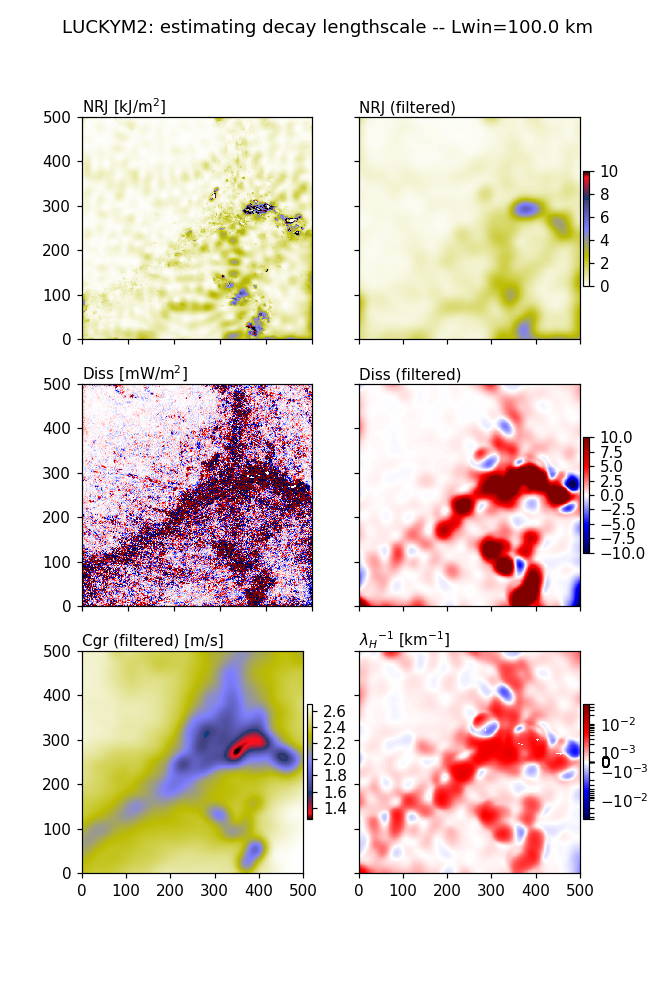

whole domain averages: 6765.7 km
ridge1: 1968.1 km
ridge2: 586.2 km
ridge3: 657.4 km
ridge4: 214.8 km
plain: 7617.1 km
islands: 245.0 km
seamounts: -1081.4 km


In [20]:
nwis = int(round(2.*Lwin/dxs))
if (nwis%2)==0: nwis += 1
print("blurring window size:", nwis)

myblur = lambda x: winblur(x, nwin=nwis, edge_mode="edge")
mast = topo[etam,:][:,xim] < 100

etob = winblur(np.where(np.isnan(etot)|mast, 0, etot), nwin=nwis, edge_mode="edge") # kJ/m^2
disb = winblur(np.where(np.isnan(diss)|mast,0, diss), nwin=nwis, edge_mode="edge") # W/m^2
taub = np.where(mast, np.nan, etob/disb) # this is in 1000 s
cgrb = winblur( np.where(np.isnan(cpha),np.nanmean(cpha*np.sqrt(1-fcom**2/omega**2)),cpha*np.sqrt(1-fcom**2/omega)) \
              , nwin=nwis, edge_mode="edge")
hscalsim = taub * cgrb # this is in km
# reblur result ?
if False:
    hscalsim = winblur(hscalsim, nwin=nwis, edge_mode="edge")

# plot results
#norm=colors.SymLogNorm(linthresh=.1, linscale=.5, vmin=-10, vmax=10)
fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(6,9))
ax = axs[0,0]
hpc = ax.pcolormesh(etot, vmin=0, vmax=10, cmap="gist_stern_r")
ax.text(0,1.02,r"NRJ [kJ/m$^2$]", transform=ax.transAxes)
ax = axs[0,1]
hpc = ax.pcolormesh(etob, vmin=0, vmax=10, cmap="gist_stern_r")
plt.colorbar(hpc, ax=ax, fraction=.025, pad=.015)
ax.text(0,1.02,"NRJ (filtered)", transform=ax.transAxes)
ax = axs[1,0]
hpc = ax.pcolormesh(diss*1e3, vmin=-10, vmax=10, cmap="seismic")
ax.text(0,1.02,r"Diss [mW/m$^2$]", transform=ax.transAxes)
ax = axs[1,1]
hpc = ax.pcolormesh(disb*1e3, vmin=-10, vmax=10, cmap="seismic")
ax.text(0,1.02,"Diss (filtered)", transform=ax.transAxes)
plt.colorbar(hpc, ax=ax, fraction=.025, pad=.015)
ax = axs[2,0]
hpc = ax.pcolormesh(cgrb, cmap="gist_stern")
ax.text(0,1.02,"Cgr (filtered) [m/s]", transform=ax.transAxes)
plt.colorbar(hpc, ax=ax, fraction=.025, pad=.015)
ax = axs[2,1]
hpc = ax.pcolormesh(1/hscalsim, norm=colors.SymLogNorm(linthresh=1e-3, linscale=.5, vmin=-5e-2, vmax=5e-2), cmap="seismic")
ax.text(0,1.02,r"${\lambda_H}^{-1}$ [km$^{-1}$]", transform=ax.transAxes)
plt.colorbar(hpc, ax=ax, fraction=.025, pad=.015)

fig.suptitle("{0}: estimating decay lengthscale -- Lwin={1:.1f} km".format(simul.upper(), Lwin/1e3))

### estimate per subdomain
hsimdom = {"full":np.nanmean(hscalsim)}
print("whole domain averages: {:.1f} km".format(hsimdom["full"]))

for dom,nam in zip(doms,nams):
    hsimdom[nam] = get_domean(hscalsim, dom, lonm, latm, maskup=(topo[:,xim][etam,:]>100))
    print("{0}: {1:.1f} km".format(nam, hsimdom[nam]))
    
if dosavefig:
    fig.savefig(dirpic+"{0}_DecayScale_simu.png".format(simul), magnification="auto", bbox_inches="tight", dpi=150)

In [50]:
np.nanmean(kemod), np.nanmean(pemod)

(0.00030697513, 0.16433777)

In [51]:
it = 200
### TODO change it to indt and take mean over time interval
### i.e. follow the same procedure as in Calc_ModalNRJ_subdom

nc = Dataset(nrjm_file,'r')
xi = nc.variables['xi_rho'][:]
eta = nc.variables['eta_rho'][:]
dxs, dys = dx*(xi[1]-xi[0]), dy*(eta[1]-eta[0])
kemod = nc.variables['ek_lf'][it,imod,:,:]*1e3/rho0
pemod = nc.variables['ep_lf'][it,imod,:,:]*1e3/rho0
divfmod = (np.gradient(nc.variables['Fx_lf'][it,imod,...], axis=-1)/dxs 
           + np.gradient(nc.variables['Fy_lf'][it,imod,...], axis=-2)/dys)*1e3#*rho0 # W/m²
nc.close()
ny, nx = kemod.shape
dhdx = (np.gradient(topo, axis=1)/dx)[:,xi][eta,:]
dhdy = (np.gradient(topo, axis=0)/dy)[:,xi][eta,:]
lons, lats = lon[:,xi][eta,:], lat[:,xi][eta,:]
tops = topo[:,xi][eta,:]
f0 = fcor[:,xi][eta,:]
nwis = int(round(Lwin/dxs))
if (nwis%2)==0: nwis += 1
print("blurring window size:", nwis)
    
# compute conversion terms (should be in W/m²) barotropic -> mode n
indt = np.arange(600,687) # 87 (7 tidal periods) seems fair, but it does vary

# set up filter
dt = 1
bb, aa = sig.butter(4, 2*dt/30)
# m=0, n

nc = Dataset(mode_file, "r")
umod = nc.variables['u_amp']
vmod = nc.variables['v_amp']
pmod = nc.variables['p_amp']
zrho = nc.variables['zrb']
cpha = nc.variables["mode_speed"][1,...]
czon = np.full((ny,nx),np.nan) # this is the conversion term
czin = np.full((ny,nx), np.nan) # baroclinic scattering

phim = nc.variables['p_modes'][0,0,...] # p0 at 0
lam = 1./nc.variables["mode_speed"][0,...]**2
lan = 1./nc.variables["mode_speed"][imod,...]**2
phin = nc.variables['p_modes'][imod,0,...]

# barotropic scattering
prov = phim*phin / (lam-lan) * (\
                    pmod[indt,0,...]*lam*(umod[indt,imod,...]*dhdx + vmod[indt,imod,...]*dhdy) + \
                    pmod[indt,imod,...]*lan*(umod[indt,0,...]*dhdx + vmod[indt,0,...]*dhdy) )
indy,indx = np.where(np.isfinite(prov[0,...]))
czon[indy,indx] = sig.filtfilt(bb, aa, prov[:,indy,indx], method="gust", axis=0).mean(axis=0)*rho0
# baroclinic scattering
print("now computing baroclinic scattering", flush=True)
prov = np.zeros((len(indt),ny,nx))
for inod in range(2,len(nc.dimensions["mode"])):
    lak = 1./nc.variables["mode_speed"][inod,...]**2
    phik = nc.variables['p_modes'][inod,0,...]
    prov += phin*phik / (lan-lak) * (\
                    pmod[indt,imod,...]*lan*(umod[indt,inod,...]*dhdx + vmod[indt,inod,...]*dhdy) + \
                    pmod[indt,inod,...]*lak*(umod[indt,imod,...]*dhdx + vmod[indt,imod,...]*dhdy) )
nc.close()
czin[indy,indx] = sig.filtfilt(bb, aa, prov[:,indy,indx], method="gust", axis=0).mean(axis=0)*rho0
diss = czon - divfmod
tau = (kemod+pemod)*1e3/(diss+czin)/(3600.*24)
taub = winblur(np.where(np.isnan(kemod+pemod), 0, kemod+pemod), nwin=nwis, edge_mode="edge")*1e3 \
            / winblur(np.where(np.isnan(diss+czin),0,diss+czin), nwin=nwis, edge_mode="edge") / (3600.*24)

# dictionnary of data per domain
data_dom = {dom:{} for dom in nams}

# print domain averages
print("full domain average:")
for field in ["kemod+pemod", "czon", "divfmod", "diss", "czin", "tau", "taub"]:
    print(field, np.nanmean(eval(field)), end=", ")
print('')
for dom,nam in zip(doms,nams):
    print(nam)
    for field in ["kemod+pemod","czon", "divfmod", "diss", "czin", "tau", "taub"]:
        prov = get_domean(eval(field), dom, lons, lats)
        print(field+" {:.2e}".format(prov), end=", ")
        data_dom[nam][field] = prov
    print('')

print('decay computed per subdomain:')
for nam,dom in zip(nams,doms):
    val = data_dom[nam]
    data_dom[nam]['tau_dom'] = val["kemod+pemod"]*1e3/val["diss"]
    data_dom[nam]['tau_scat'] = val["kemod+pemod"]*1e3/val["czin"]
    data_dom[nam]['tau_tot'] = val["kemod+pemod"]*1e3/(val["diss"]+val["czin"])
    data_dom[nam]['tau_nonlin'] = val["kemod+pemod"]*1e3/(val['diss']-val['czin'])
    data_dom[nam]["group_speed"] = get_domean(cpha*np.sqrt(1-(f0/omega)**2), dom, lons, lats)
    for fie in ['dom', 'scat', 'tot']:
        prov = data_dom[nam]['tau_'+fie]
        print(nam, fie, "{0:.2f} days, {1:.1f} km".format(prov/(3600*24.), prov*data_dom[nam]["group_speed"]/1e3))

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater
/home/laha

blurring window size: 33


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


now computing baroclinic scattering


/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater


full domain average:
kemod+pemod 0.471313, czon 0.00205781890272, divfmod 0.000363141, diss 0.00168164601495, czin 0.000803463327641, tau 3.67670704026, taub 6.65498844852, 
ridge1
kemod+pemod 2.21e-01, czon 2.50e-04, divfmod -5.90e-04, diss 8.40e-04, czin 8.74e-04, tau 4.70e-03, taub 2.47e-01, 
ridge2
kemod+pemod 5.68e-01, czon 3.05e-03, divfmod -4.13e-04, diss 3.46e-03, czin 2.74e-03, tau 3.54e+00, taub 1.28e+00, 
ridge3
kemod+pemod 5.62e-01, czon 4.84e-03, divfmod 5.09e-04, diss 4.09e-03, czin 2.16e-03, tau -7.29e-01, taub 9.44e-01, 
ridge4
kemod+pemod 2.48e-01, czon 9.74e-04, divfmod 3.36e-04, diss 6.38e-04, czin 5.96e-04, tau -8.01e-01, taub 7.50e-01, 
plain
kemod+pemod 1.77e-01, czon 1.33e-04, divfmod -1.07e-04, diss 2.40e-04, czin 4.40e-05, tau -1.79e+00, taub 8.47e+00, 
islands
kemod+pemod 1.20e+00, czon 7.55e-03, divfmod 5.49e-05, diss 7.52e-03, czin 1.06e-04, tau -3.02e+00, taub 6.67e-01, 
seamounts
kemod+pemod 1.82e+00, czon 2.38e-02, divfmod 1.33e-02, diss 1.05e-02, czin 6.

<IPython.core.display.Javascript object>


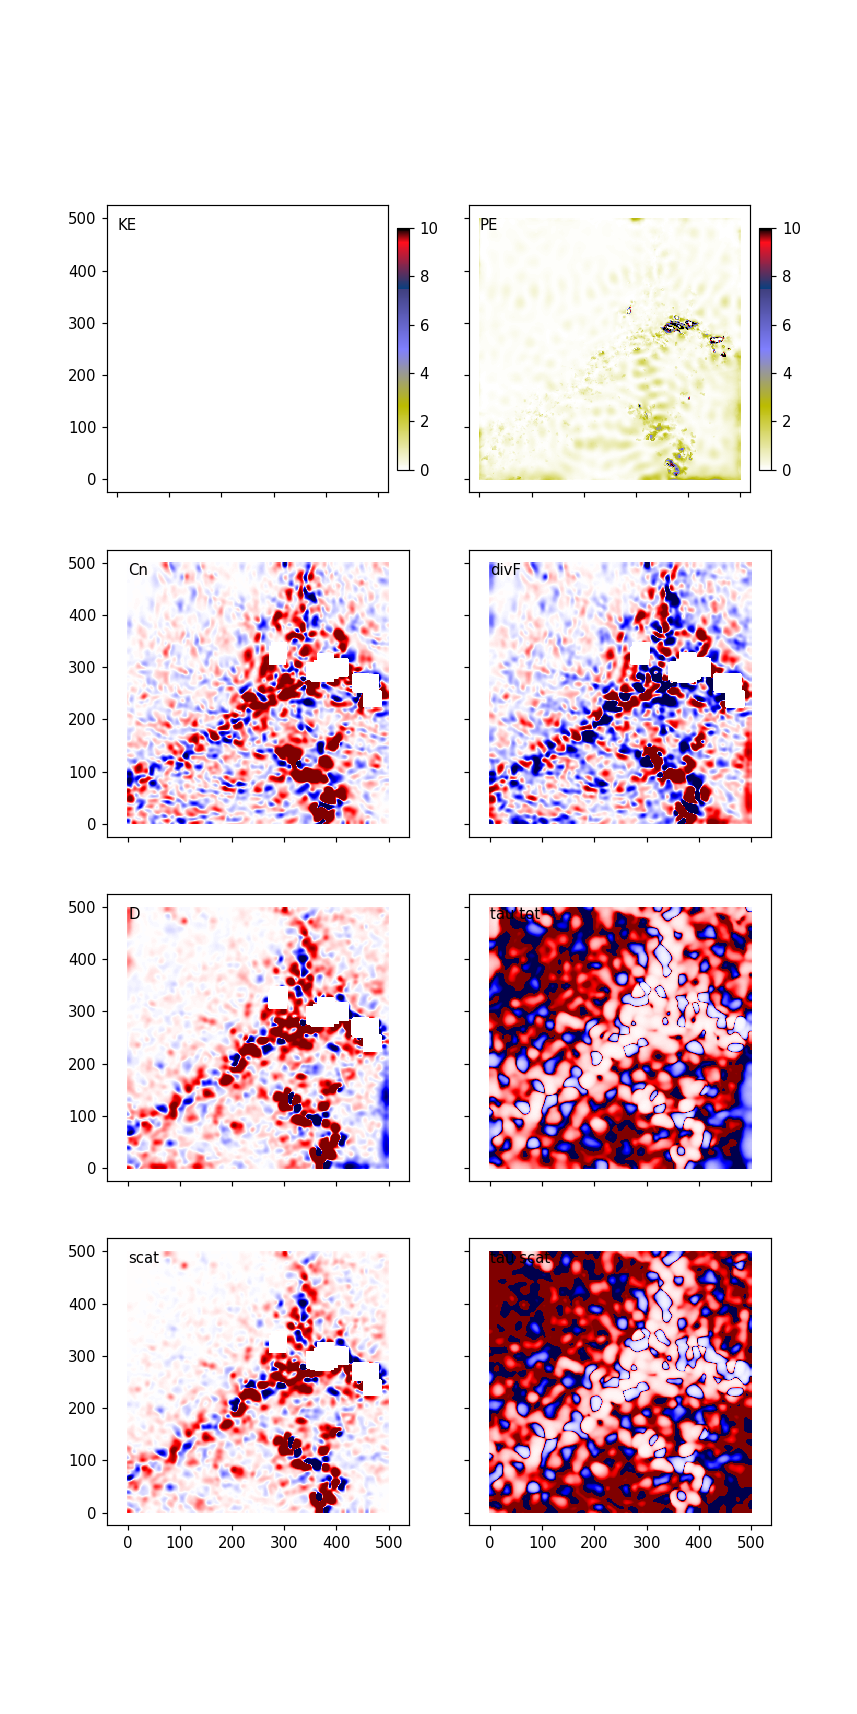

In [139]:
### plot result
cmap = "gist_stern_r"

fig, bxs = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(8,16))
axs = bxs.ravel()
ax = axs[0]
hpc = ax.pcolormesh(kemod, cmap=cmap, vmin=0, vmax=10)
plt.colorbar(hpc, ax=ax, fraction=.04, pad=.03)
ax.text(1, ny, "KE", va="top")
ax = axs[1]
hpc = ax.pcolormesh(pemod, cmap=cmap, vmin=0, vmax=10)
plt.colorbar(hpc, ax=ax, fraction=.04, pad=.03)
ax.text(1, ny, "PE", va="top")
ax = axs[2]
hpc = ax.pcolormesh(blurfun(czon)*1e3, cmap="seismic", vmin=-10, vmax=10)
ax.text(1, ny, "Cn", va="top")
ax = axs[3]
hpc = ax.pcolormesh(blurfun(divfmod)*1e3, cmap="seismic", vmin=-10, vmax=10)
ax.text(1, ny, "divF", va="top")
ax = axs[4]
hpc = ax.pcolormesh(blurfun(diss)*1e3, cmap="seismic", vmin=-10, vmax=10)
ax.text(1, ny, "D", va="top")
ax = axs[5]
hpc = ax.pcolormesh(taub, cmap="seismic", vmin=-10, vmax=10)
ax.text(1, ny, "tau tot", va="top")
ax = axs[6]
hpc = ax.pcolormesh(blurfun(czin)*1e3, cmap="seismic", vmin=-10, vmax=10)
ax.text(1, ny, "scat", va="top")
ax = axs[7]
hpc = ax.pcolormesh(myblur(np.where(np.isnan(kemod+pemod), 0, kemod+pemod), nwin=nwis, edge_mode="edge")*1e3 \
            / myblur(np.where(np.isnan(czin),0,czin), nwin=nwis, edge_mode="edge") / (3600.*24), cmap="seismic" \
                    , vmin=-10, vmax=10)
ax.text(1, ny, "tau scat", va="top")

for ax in axs:
    ax.set_aspect(1)
    ax.axis([0, nx, 0, ny])
    

<IPython.core.display.Javascript object>


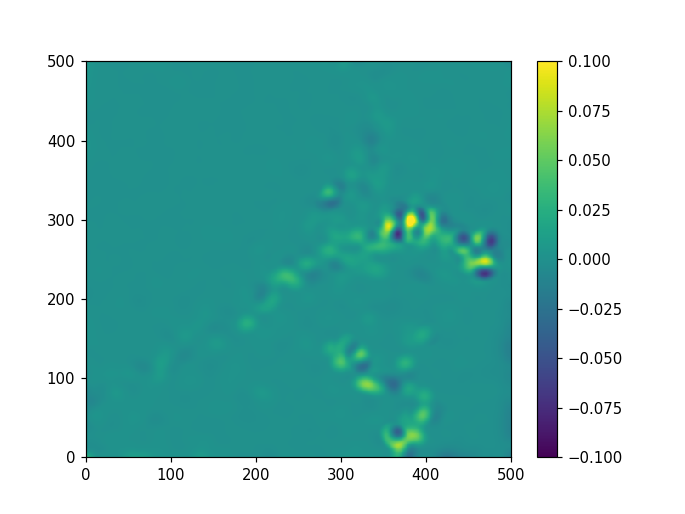

In [133]:
plt.figure()
plt.pcolormesh(myblur(np.where(np.isnan(diss), 0, diss), nwin=nwis, edge_mode="edge"), vmin=-1e-1, vmax=1e-1)
plt.colorbar()

In [100]:
plt.pcolormesh(np.isnan(diss)==np.isnan(kemod))

## Old stuff

<IPython.core.display.Javascript object>


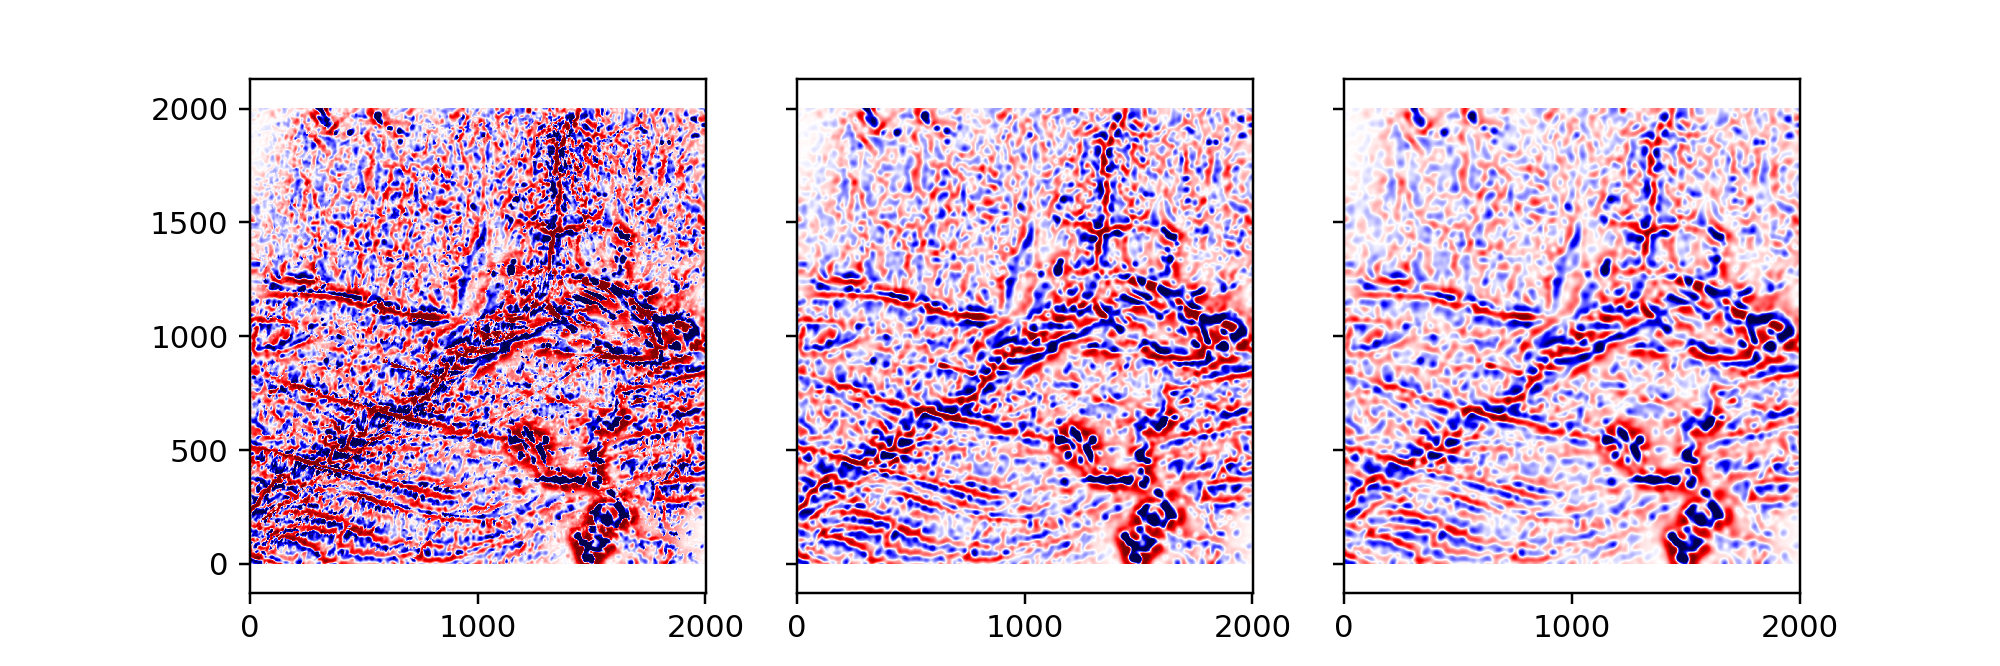

In [57]:
### compare different blurring function / moving averages

toplot = topo-hmoy
vamp = 500
cmap = "seismic"
nwin = 20

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(9,3))
axs[0].pcolormesh(toplot, vmin=-vamp, vmax=vamp, cmap=cmap)
axs[1].pcolormesh(myblur(toplot, nwin=nwin*2), vmin=-vamp, vmax=vamp, cmap=cmap)
axs[2].pcolormesh(gaussian_filter(toplot, sigma=nwin//2), vmin=-vamp, vmax=vamp, cmap=cmap)

for ax in axs:
    ax.set_aspect(1)

<IPython.core.display.Javascript object>


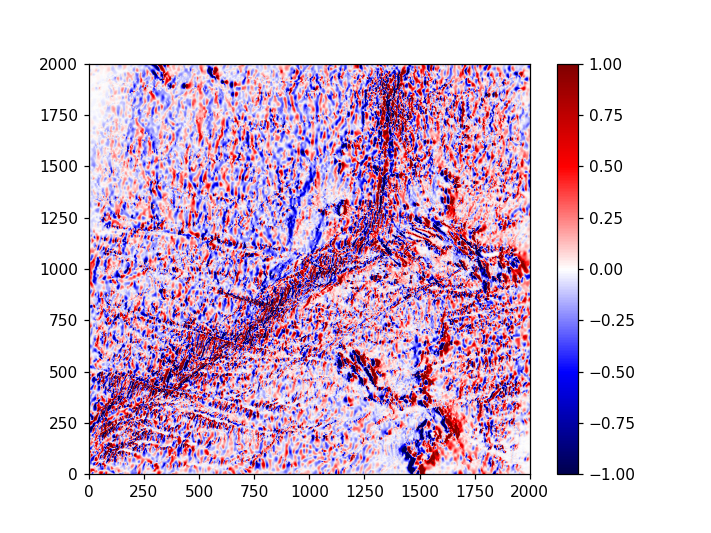

In [44]:
prav = np.diff(topo, axis=1)/dx
plt.figure()
plt.pcolormesh(prav*1e1, vmin=-1, vmax=1, cmap="seismic", shading="gouraud")
plt.colorbar()

In [89]:
phim.shape, phin.shape, lam.shape, lan.shape

((500, 500), (2, 500, 500), (500, 500), (2, 500, 500))

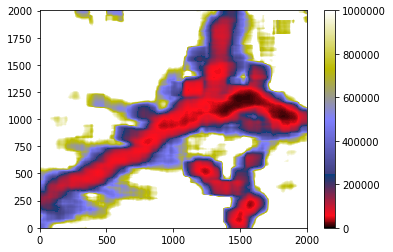

In [60]:
plt.pcolormesh(hscale, vmin=0, vmax=1e6, cmap="gist_stern")#, vmin=-100, vmax=100)
plt.colorbar()